## Effort Matters
Clara Wong
400372818

## Set up + Data Loading

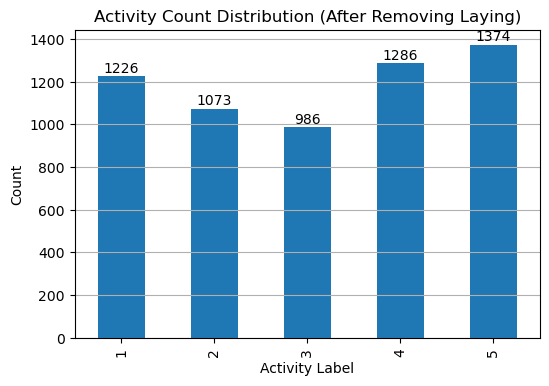

Raw activity counts:
0
1    1226
2    1073
3     986
4    1286
5    1374
Name: count, dtype: int64


In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Load training data
train_path = 'assignment4_data/train/'

# Load activity data and labels
y_train = pd.read_csv(train_path + 'y_train.txt', delim_whitespace=True, header=None)
X_train = pd.read_csv(train_path + 'X_train.txt', delim_whitespace=True, header=None)

# Load raw accelerometer data
acc_x = pd.read_csv(train_path + 'Inertial Signals/body_acc_x_train.txt', delim_whitespace=True, header=None)
acc_y = pd.read_csv(train_path + 'Inertial Signals/body_acc_y_train.txt', delim_whitespace=True, header=None)
acc_z = pd.read_csv(train_path + 'Inertial Signals/body_acc_z_train.txt', delim_whitespace=True, header=None)

# Exclude laying for simplicity
exclude_laying = y_train[0] != 6

# Get the indices of the rows to keep
indices_to_keep = exclude_laying[exclude_laying].index

# Filter both y_test and X_test
y_train = y_train.loc[indices_to_keep].reset_index(drop=True)
X_train = X_train.loc[indices_to_keep].reset_index(drop=True)

acc_x = acc_x.loc[indices_to_keep].reset_index(drop=True)
acc_y = acc_y.loc[indices_to_keep].reset_index(drop=True)
acc_z = acc_z.loc[indices_to_keep].reset_index(drop=True)

# Show data distribution after removing laying
plt.figure(figsize=(6,4))
counts_raw = y_train[0].value_counts().sort_index()
bars = counts_raw.plot(kind='bar')

# Add number labels on top of bars
for i, value in enumerate(counts_raw):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=10)
plt.title("Activity Count Distribution (After Removing Laying)")
plt.xlabel("Activity Label")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()

print("Raw activity counts:")
print(y_train[0].value_counts().sort_index())

## 2) Feature Engineering
Based on your knowledge from the HAR literature, compute or
select features1 (e.g., mean, variance, signal magnitude area, FFT energy) and define a relevant
custom feature of your own with concise justification. You must use a minimum of 3 features
in your model (including your own) and no more than 5 features (including your own)

In [37]:
def compute_features(acc_x, acc_y, acc_z, x_data):
    ## Features extracted: 201 tBodyAccMag-mean(), 202 tBodyAccMag-std(), 16 tBodyAcc-sma(), 227 tBodyAccJerkMag-mean()
    features = pd.DataFrame()

    # Columns you want to extract (Python is 0-indexed)
    columns_to_extract = [15, 200, 201, 226] 

    selected_X_data = x_data.iloc[:, columns_to_extract].values

    # Extract selected features
    features['mean_acc'] = selected_X_data[:, 0]
    features['std_acc'] = selected_X_data[:, 1]
    features['sma_acc'] = selected_X_data[:, 2]
    features['mean_jerk_acc'] = selected_X_data[:, 3]

    mag_acc = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)
    
    # Custom Feature: Peak to peak magnitude
    features['peak_to_peak_acc'] = np.max(mag_acc, axis=1) - np.min(mag_acc, axis=1)

    selected_features = features[['mean_acc', 'std_acc', 'sma_acc', 'mean_jerk_acc', 'peak_to_peak_acc']]
    
    return selected_features
   

## Model Training
Train an SVM (RBF) to separate low- vs high-intensity window

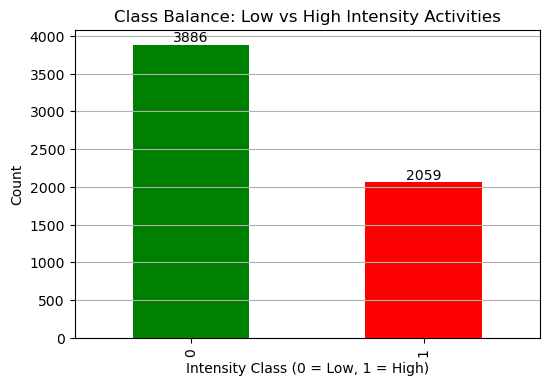


Mapped intensity counts:
0
0    3886
1    2059
Name: count, dtype: int64


SVC()

In [38]:
def map_intensity(outcome):
    # 0 = low-intensity, 1 = high-intensity
    return outcome.replace({1: 0, 2: 1, 3: 1, 4: 0, 5: 0})

y_train = map_intensity(y_train)

# low vs high intensity class balance
plt.figure(figsize=(6,4))
counts_intensity = pd.Series(y_train[0]).value_counts().sort_index()
bars = counts_intensity.plot(kind='bar', color=['green', 'red'])

# Add number labels on bars
for i, value in enumerate(counts_intensity):
    plt.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=10)

plt.title("Class Balance: Low vs High Intensity Activities")
plt.xlabel("Intensity Class (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()

print("\nMapped intensity counts:")
print(pd.Series(y_train[0]).value_counts().sort_index())

y_train = y_train.values.ravel()

# Compute features for training
X_train_features = compute_features(acc_x.values, acc_y.values, acc_z.values, X_train)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)

# train SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

## Evaluation
Report confusion matrix, accuracy, precision, recall, F1; include at least one
visualization (e.g., decision visualization).

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1519
           1       0.98      0.91      0.94       891

    accuracy                           0.96      2410
   macro avg       0.96      0.95      0.96      2410
weighted avg       0.96      0.96      0.96      2410

Test Accuracy: 0.9589
Test Precision: 0.9783
Test Recall: 0.9091
Test F1-Score: 0.9424
Confusion Matrix:
 [[1501   18]
 [  81  810]]


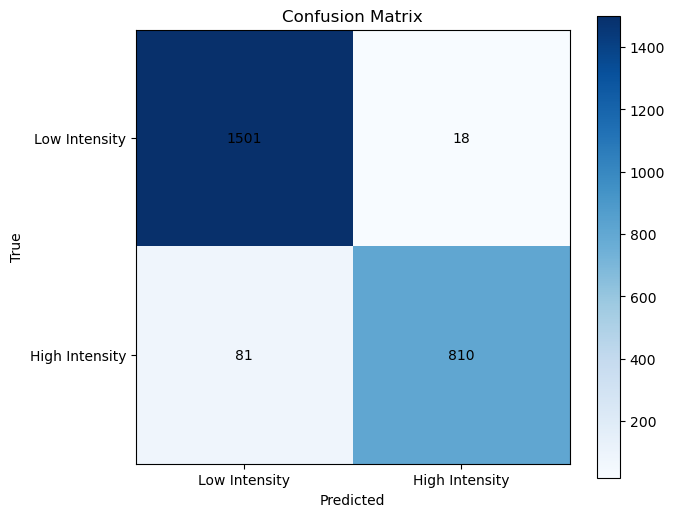

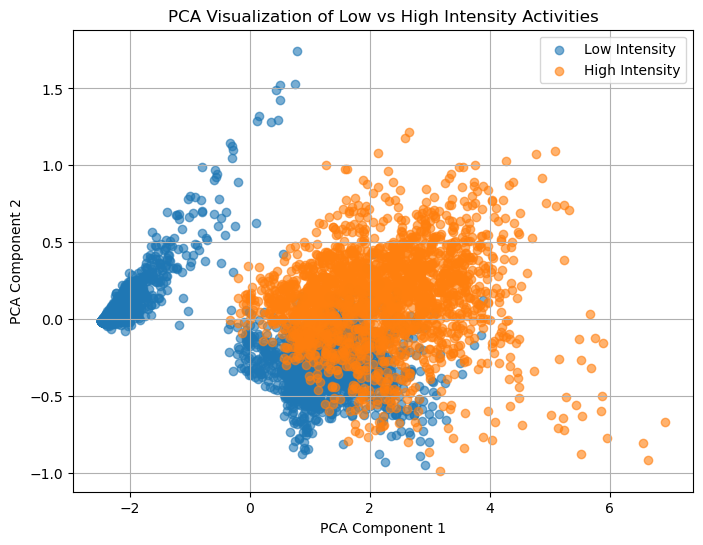

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA

# load testing data
test_path = 'assignment4_data/test/'

y_test = pd.read_csv(test_path + 'y_test.txt', delim_whitespace=True, header=None)
X_test = pd.read_csv(test_path + 'X_test.txt', delim_whitespace=True, header=None)

acc_x_test = pd.read_csv(test_path + 'Inertial Signals/body_acc_x_test.txt', delim_whitespace=True, header=None)
acc_y_test = pd.read_csv(test_path + 'Inertial Signals/body_acc_y_test.txt', delim_whitespace=True, header=None)
acc_z_test = pd.read_csv(test_path + 'Inertial Signals/body_acc_z_test.txt', delim_whitespace=True, header=None)

# Exclude laying for simplicity
exclude_laying = y_test[0] != 6

# Get the indices of the rows to keep
indices_to_keep = exclude_laying[exclude_laying].index

acc_x_test = acc_x_test.loc[indices_to_keep].reset_index(drop=True)
acc_y_test = acc_y_test.loc[indices_to_keep].reset_index(drop=True)
acc_z_test = acc_z_test.loc[indices_to_keep].reset_index(drop=True)
y_test = y_test.loc[indices_to_keep].reset_index(drop=True)
X_test = X_test.loc[indices_to_keep].reset_index(drop=True)

y_test = map_intensity(y_test)

# Compute features for test set
X_test_features = compute_features(acc_x_test.values, acc_y_test.values, acc_z_test.values, X_test)
X_test_scaled = scaler.transform(X_test_features)

# evaluate the model
y_pred = svm_model.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Visualize Confusion Matrix
plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()

classes = ["Low Intensity", "High Intensity"]

# Axis labels
plt.xticks(np.arange(2), classes)
plt.yticks(np.arange(2), classes)

# label squares
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# PCA on the feature-scaled data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[y_train == 0, 0], X_pca[y_train == 0, 1], alpha=0.6, label='Low Intensity')
plt.scatter(X_pca[y_train == 1, 0], X_pca[y_train == 1, 1], alpha=0.6, label='High Intensity')

plt.title("PCA Visualization of Low vs High Intensity Activities")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


## BONUS
Cross-subject test or additional metric (e.g., ROC-AUC) with a brief implications paragraph

ROC-AUC Score: 0.9932091007359825


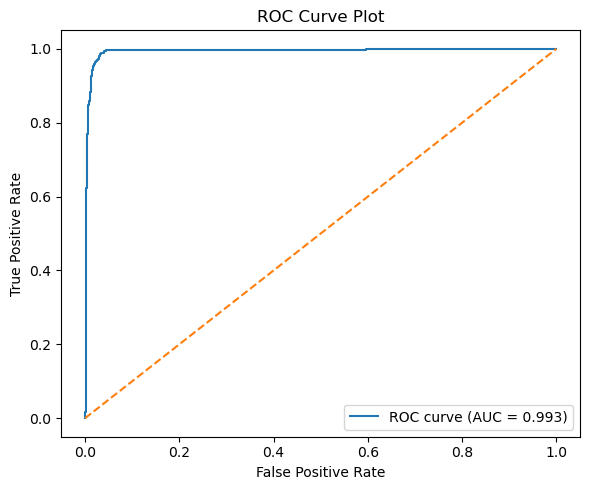

In [40]:
from sklearn.metrics import roc_curve, auc
y_score = svm_model.decision_function(X_test_scaled)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute AUC
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

# ROC curve plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")  # chance line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Plot")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()